Training Standard LSTM Model...


Epoch 1: Train Loss: 0.051089, Val Loss: 0.401191


Epoch 2: Train Loss: 0.000418, Val Loss: 0.129035


Epoch 3: Train Loss: 0.000182, Val Loss: 0.052835


Epoch 4: Train Loss: 0.000142, Val Loss: 0.031996


Epoch 5: Train Loss: 0.000128, Val Loss: 0.023046


Epoch 6: Train Loss: 0.000121, Val Loss: 0.013414


Epoch 7: Train Loss: 0.000116, Val Loss: 0.011516


Epoch 8: Train Loss: 0.000113, Val Loss: 0.006926


Epoch 9: Train Loss: 0.000112, Val Loss: 0.006873


Epoch 10: Train Loss: 0.000111, Val Loss: 0.006201


Epoch 11: Train Loss: 0.000111, Val Loss: 0.005904


Epoch 12: Train Loss: 0.000111, Val Loss: 0.005223


Epoch 13: Train Loss: 0.000111, Val Loss: 0.004941


Epoch 14: Train Loss: 0.000111, Val Loss: 0.005831


Epoch 15: Train Loss: 0.000111, Val Loss: 0.004784


Epoch 16: Train Loss: 0.000110, Val Loss: 0.002128


Epoch 17: Train Loss: 0.000110, Val Loss: 0.003827


Epoch 18: Train Loss: 0.000110, Val Loss: 0.004232


Epoch 19: Train Loss: 0.000111, Val Loss: 0.003573


Epoch 20: Train Loss: 0.000110, Val Loss: 0.003762


Epoch 21: Train Loss: 0.000110, Val Loss: 0.004046
Early stopping triggered at epoch 21
Standard LSTM Eval Metrics:
MSE: 0.0024257912120208766
Average Inference Time per Sample (s): 0.0002057719561788771
Standard LSTM model weights saved as 'standard_lstm_weights.pth'.

Training OPTM-LSTM Model...


Epoch 1: Train Loss: 0.078309, Val Loss: 7.550123


Epoch 2: Train Loss: 0.000534, Val Loss: 9.338129


Epoch 3: Train Loss: 0.000219, Val Loss: 9.655124


Epoch 4: Train Loss: 0.000138, Val Loss: 0.631349


Epoch 5: Train Loss: 0.000122, Val Loss: 0.685777


Epoch 6: Train Loss: 0.000118, Val Loss: 0.702971


Epoch 7: Train Loss: 0.000116, Val Loss: 0.726806


Epoch 8: Train Loss: 0.000114, Val Loss: 0.714207


Epoch 9: Train Loss: 0.000113, Val Loss: 0.711545
Early stopping triggered at epoch 9
OPTM-LSTM Eval Metrics:
MSE: 0.7115445151658141
Average Inference Time per Sample (s): 0.0012862643157994305
OPTM-LSTM model weights saved as 'optmlstm_weights.pth'.

Standard LSTM Test Metrics:
MSE: 0.00012487909488536378
Average Inference Time per Sample (s): 0.00019987554599841436

OPTM-LSTM Test Metrics:
MSE: 0.00010991496813604535
Average Inference Time per Sample (s): 0.0012549555113102182

Standard LSTM Accuracy Metrics:
MSE: 0.0001248790940735489
Directional Accuracy: 0.3582851080246914
Tolerance Accuracy: 0.004021990740740741

OPTM-LSTM Accuracy Metrics:
MSE: 0.00010991497401846573
Directional Accuracy: 0.3581983024691358
Tolerance Accuracy: 0.005025077160493827


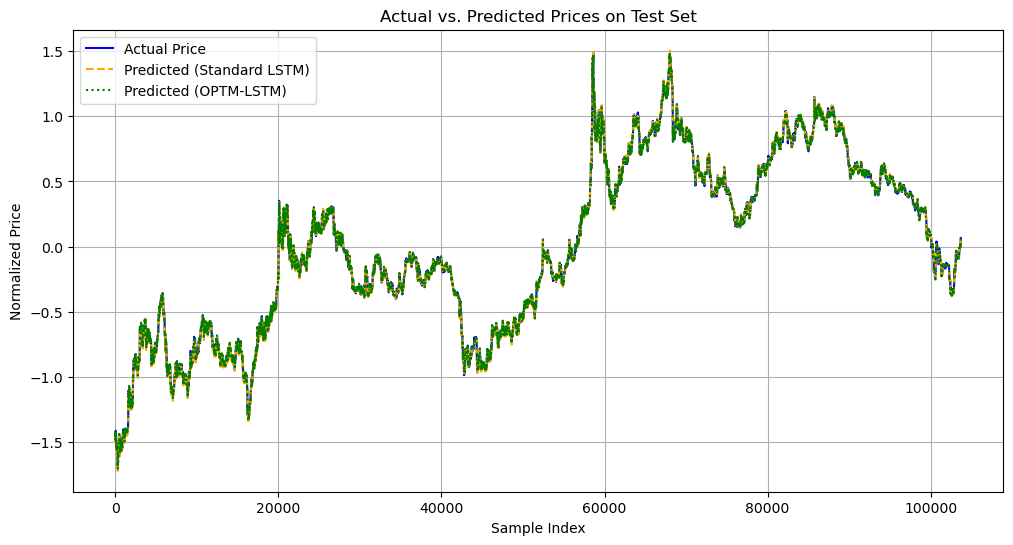

In [6]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# =============================================================================
# Data Preparation (Based on HFT LOB Data)
# =============================================================================
file_path = "datasets/test.csv"
data = pd.read_csv(file_path)

levels = 5
bid_price_cols = [f"bids[{i}].price" for i in range(levels)]
ask_price_cols = [f"asks[{i}].price" for i in range(levels)]
feature_columns = bid_price_cols + ask_price_cols

data["target"] = data["mark_price"].shift(-1)
data.dropna(inplace=True)

data["mid_price"] = (data[bid_price_cols[0]] + data[ask_price_cols[0]]) / 2

scaler_X = StandardScaler()
scaler_y = StandardScaler()
data[feature_columns] = scaler_X.fit_transform(data[feature_columns])
data["target"] = scaler_y.fit_transform(data[["target"]])
data["mid_price"] = scaler_y.fit_transform(data[["mid_price"]])

n = len(data)
train_end = int(0.6 * n)
test_end = int(0.9 * n)
train_data = data.iloc[:train_end].reset_index(drop=True)
test_data = data.iloc[train_end:test_end].reset_index(drop=True)
eval_data = data.iloc[test_end:].reset_index(drop=True)

# =============================================================================
# Dataset Definition (Combined Input)
# =============================================================================
class HFTDatasetCombined(Dataset):
    def __init__(self, df, feature_cols, guarantor_col, target_col):
        self.X_features = df[feature_cols].values.astype(np.float32)
        self.guarantor = df[guarantor_col].values.astype(np.float32).reshape(-1, 1)
        self.X = np.concatenate([self.X_features, self.guarantor], axis=1)
        self.y = df[target_col].values.astype(np.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return x, y

batch_size = 64
train_dataset = HFTDatasetCombined(train_data, feature_columns, "mid_price", "target")
test_dataset = HFTDatasetCombined(test_data, feature_columns, "mid_price", "target")
eval_dataset = HFTDatasetCombined(eval_data, feature_columns, "mid_price", "target")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

# =============================================================================
# OPTM-LSTM Cell (PyTorch Implementation)
# =============================================================================
class OPTMLSTMCellTorch(nn.Module):
    def __init__(self, input_dim, hidden_size, gd_iters=7, gd_lr=0.0001):
        super(OPTMLSTMCellTorch, self).__init__()
        self.hidden_size = hidden_size
        self.gd_iters = gd_iters
        self.gd_lr = gd_lr
        self.linear = nn.Linear(input_dim, 4 * hidden_size, bias=True)
        self.recurrent_linear = nn.Linear(hidden_size, 4 * hidden_size, bias=False)
        self.sigmoid = torch.sigmoid
        self.tanh = torch.tanh

    def forward(self, x, h, c):
        x_features = x[:, :-1]
        guarantor = x[:, -1].view(-1, 1)
        
        z = self.linear(x_features) + self.recurrent_linear(h)
        z_i, z_f, z_c, z_o = z.chunk(4, dim=1)
        i = self.sigmoid(z_i)
        f = self.sigmoid(z_f)
        c_t = self.tanh(z_c)
        o = self.sigmoid(z_o)
        c_new = f * c + i * c_t
        h_temp = o * self.tanh(c_new)
        
        gated_vector = torch.cat([i, f, c_t, c_new, o, h_temp], dim=1)
        theta = torch.ones(6 * self.hidden_size, 1, device=x.device)
        for _ in range(self.gd_iters):
            y_pred = gated_vector @ theta
            error = y_pred - guarantor
            grad = (2 / x.size(0)) * (gated_vector.t() @ error)
            theta = theta - self.gd_lr * grad

        theta_parts = torch.chunk(theta, 6, dim=0)
        importance = [torch.mean(torch.abs(part)) for part in theta_parts]
        importance_stack = torch.stack(importance)
        max_idx = torch.argmax(importance_stack)

        if max_idx.item() == 0:
            new_h = i
        elif max_idx.item() == 1:
            new_h = f
        elif max_idx.item() == 2:
            new_h = c_t
        elif max_idx.item() == 3:
            new_h = c_new
        elif max_idx.item() == 4:
            new_h = o
        else:
            new_h = h_temp
        
        return new_h, c_new

# =============================================================================
# OPTM-LSTM Model
# =============================================================================
class OPTMLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(OPTMLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.cell = OPTMLSTMCellTorch(input_dim=input_size - 1, hidden_size=hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        seq_len, batch, _ = x.shape
        device = x.device
        h = torch.zeros(batch, self.hidden_size, device=device)
        c = torch.zeros(batch, self.hidden_size, device=device)
        for t in range(seq_len):
            x_t = x[t]
            h, c = self.cell(x_t, h, c)
        out = self.fc(h)
        return out

# =============================================================================
# Standard LSTM Model (for Comparison)
# =============================================================================
class StandardLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(StandardLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[-1]
        out = self.fc(out)
        return out

# =============================================================================
# Evaluation Metrics (Accuracy)
# =============================================================================
def compute_accuracy_metrics(preds, actuals, tol_factor=0.0001):
    preds_flat = preds.flatten()
    actuals_flat = actuals.flatten()
    mse = np.mean((preds_flat - actuals_flat) ** 2)
    
    actual_diff = np.sign(np.diff(actuals_flat, prepend=actuals_flat[0]))
    pred_diff = np.sign(np.diff(preds_flat, prepend=preds_flat[0]))
    directional_accuracy = np.mean(actual_diff == pred_diff)
    
    tol = tol_factor * np.mean(np.abs(actuals_flat))
    tolerance_accuracy = np.mean(np.abs(preds_flat - actuals_flat) <= tol)
    
    return {"MSE": mse,
            "Directional Accuracy": directional_accuracy,
            "Tolerance Accuracy": tolerance_accuracy}

# =============================================================================
# Training and Evaluation Functions with Early Stopping
# =============================================================================
def evaluate_model(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    total_loss = 0.0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for x, y in loader:
            x = x.unsqueeze(0).to(device)
            y = y.view(-1, 1).to(device)
            output = model(x)
            loss = criterion(output, y)
            total_loss += loss.item() * x.size(1)
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss

def evaluate_model_with_preds(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    preds = []
    actuals = []
    infer_times = []
    criterion = nn.MSELoss()
    total_loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            x = x.unsqueeze(0).to(device)
            y = y.view(-1, 1).to(device)
            start = time.time()
            output = model(x)
            end = time.time()
            infer_times.append((end - start) / x.size(1))
            loss = criterion(output, y)
            total_loss += loss.item() * x.size(1)
            preds.append(output.cpu().numpy())
            actuals.append(y.cpu().numpy())
    preds = np.vstack(preds)
    actuals = np.vstack(actuals)
    mse = total_loss / len(loader.dataset)
    avg_infer_time = np.mean(infer_times)
    metrics = {"MSE": mse, "Average Inference Time per Sample (s)": avg_infer_time}
    return metrics, preds, actuals

def train_model(model, train_loader, val_loader, num_epochs=50, lr=0.001, patience=5, min_delta=0.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    info_matrix = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False)
        for x, y in train_bar:
            x = x.unsqueeze(0).to(device)  # (seq_len=1, batch, input_size)
            y = y.view(-1, 1).to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * x.size(1)
            train_bar.set_postfix(loss=f"{loss.item():.6f}")
        
        avg_train_loss = epoch_loss / len(train_loader.dataset)
        val_loss = evaluate_model(model, val_loader)
        info = {'epoch': epoch + 1, 'train_loss': avg_train_loss, 'val_loss': val_loss}
        info_matrix.append(info)
        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")
        
        # Early Stopping Check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break

    return model, info_matrix

# =============================================================================
# Main Experiment: Train, Evaluate, and Test (Hidden)
# =============================================================================
input_size_combined = len(feature_columns) + 1
hidden_size = 64

# Train Standard LSTM Model
model_lstm = StandardLSTM(input_size_combined, hidden_size)
print("Training Standard LSTM Model...")
model_lstm, info_matrix_lstm = train_model(model_lstm, train_loader, eval_loader, num_epochs=50, lr=0.0001, patience=5)
metrics_lstm_eval, preds_lstm_eval, actuals_lstm_eval = evaluate_model_with_preds(model_lstm, eval_loader)
print("Standard LSTM Eval Metrics:")
for k, v in metrics_lstm_eval.items():
    print(f"{k}: {v}")

# Save Standard LSTM weights
torch.save(model_lstm.state_dict(), "standard_lstm_weights.pth")
print("Standard LSTM model weights saved as 'standard_lstm_weights.pth'.")

# Train OPTM-LSTM Model
model_optm = OPTMLSTM(input_size_combined, hidden_size)
print("\nTraining OPTM-LSTM Model...")
model_optm, info_matrix_optm = train_model(model_optm, train_loader, eval_loader, num_epochs=50, lr=0.0001, patience=5)
metrics_optm_eval, preds_optm_eval, actuals_optm_eval = evaluate_model_with_preds(model_optm, eval_loader)
print("OPTM-LSTM Eval Metrics:")
for k, v in metrics_optm_eval.items():
    print(f"{k}: {v}")

# Save OPTM-LSTM weights
torch.save(model_optm.state_dict(), "optmlstm_weights.pth")
print("OPTM-LSTM model weights saved as 'optmlstm_weights.pth'.")

# =============================================================================
# Performance Check on Test Set and Accuracy Evaluation
# =============================================================================
metrics_lstm_test, preds_lstm_test, actuals_lstm_test = evaluate_model_with_preds(model_lstm, test_loader)
metrics_optm_test, preds_optm_test, actuals_optm_test = evaluate_model_with_preds(model_optm, test_loader)

print("\nStandard LSTM Test Metrics:")
for k, v in metrics_lstm_test.items():
    print(f"{k}: {v}")
print("\nOPTM-LSTM Test Metrics:")
for k, v in metrics_optm_test.items():
    print(f"{k}: {v}")

acc_metrics_lstm = compute_accuracy_metrics(preds_lstm_test, actuals_lstm_test)
acc_metrics_optm = compute_accuracy_metrics(preds_optm_test, actuals_optm_test)

print("\nStandard LSTM Accuracy Metrics:")
for k, v in acc_metrics_lstm.items():
    print(f"{k}: {v}")
print("\nOPTM-LSTM Accuracy Metrics:")
for k, v in acc_metrics_optm.items():
    print(f"{k}: {v}")

# Plot Actual vs. Predicted Prices on Test Set
plt.figure(figsize=(12, 6))
plt.plot(actuals_lstm_test.flatten(), label="Actual Price", color="blue")
plt.plot(preds_lstm_test.flatten(), label="Predicted (Standard LSTM)", color="orange", linestyle="--")
plt.plot(preds_optm_test.flatten(), label="Predicted (OPTM-LSTM)", color="green", linestyle=":")
plt.title("Actual vs. Predicted Prices on Test Set")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Price")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# pip install tardis-dev
# requires Python >=3.6
from tardis_dev import datasets

datasets.download(
    exchange="deribit",
    data_types=[
        "incremental_book_L2",
        "trades",
        "quotes",
        "derivative_ticker",
        "book_snapshot_25",
        "liquidations"
    ],
    from_date="2025-03-01",
    to_date="2019-03-02",
    symbols=["BTC-PERPETUAL"],
    save_path="./datasets/"
)